# Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

# Загрузка и подготовка данных

Изображения в базе данных MNIST представляют собой квадраты 28 х 28 в градациях серого цвета,
где 0 - черный цвет, 255 - белый.

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [16]:
## Отображение данных

Посмотрим что вообще представляют из себя наши данные

In [17]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Как уже говорилось ранее, один элемент выборки (суть - одна цифра) - это массив размером 28 х 28, 
где каждый элемент этого массива является целым числом, интерпретируемым как градация по шкале серого цвета
от 0 (черный цвет) до 255 (белый цвет).

Тем не менее мы можем вывести графическое представление нашей выборки.
Чтобы лучше понимать с чем мы имеем дело, отобразим первые 25 элементов. 

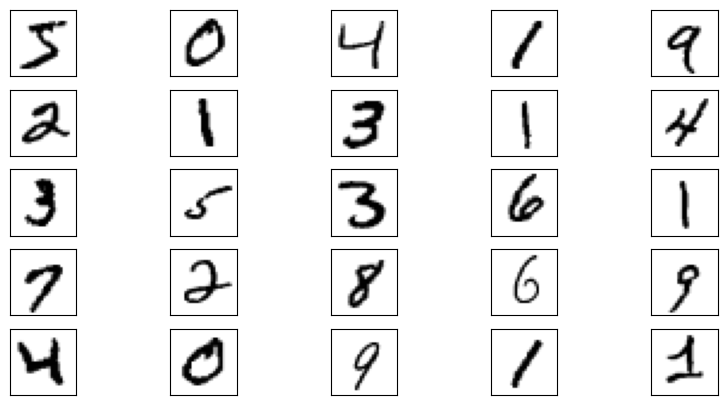

In [18]:
plt.figure(figsize=(10, 5))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)

plt.show()

## Нормализация данных

Разделим каждое значение в данных на 255 (максимально возможное значение)
для того, чтобы привести данные к диапазону [0; 1]

In [19]:
X_train = X_train / 255
X_test = X_test / 255

Посмотрим на таргет

In [20]:
y_train[0]

5

Таргет представляет собой цифры, соответствующие тому, что нарисовано на картинках.
Но модель будет иметь на выходе 10 нейронов, и выдавать вектор из 10 значений с 
вероятностями принадлежности значения на входе к одному из 10 классов.

Поэтому нужно преобразовать выходные значения в векторы из 10 элементов

In [21]:
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

In [22]:
y_train_cat[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

В Keras на входе каждого сверточного слоя ожидаются данные в формате:
(batch, channels, rows, cols) - если data_format='channels_first'
(batch, rows, cols, channels) - если data_format='channels_last' - по умолчанию
batch - размер батча;
rows, cols - строк и столбцов во входном изображении или карте признаков;
channels - количество каналов: =1 для ч/б изображения, =3 для цветного, для карты признаков =количество каналов

Это значит, что входные коллекции X_train и X_test должны иметь размерность:
(batch, rows = 28, cols = 28, channels = 1)
но сейчас они имеют размерность: 
(batch, rows = 28, cols = 28)

Для того чтобы изменить размерность, добавим четвертую ось в коллекции X_train и X_test

In [23]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


# Сверточная нейронная сеть

## Формирование и компиляция модели

In [24]:
model = keras.Sequential([
    # Входное изображение - 28 х 28 х 1
    Conv2D(
        filters=32,  # число ядер (каналов)
        kernel_size=(3, 3),  # размер ядра
        strides=(1, 1),  # шаг сканирования фильтров по осям плоскости
        padding='same',  # размер выходной карты признаков
        activation='relu',  # функция активации
        input_shape=(28, 28, 1)  # формат входных данных: 28 х 28 пикселей в градациях серого
    ),  
    # на выходе получаем 28 Х 28 Х 32 канала
    
    MaxPooling2D(
        pool_size=(2, 2),  # размер окна, в котором выбирается максимальное значение
        strides=2,  # шаг сканирования по координатам; при размере рамки 2х2 и шаге 2 рамки не будут пересекаться
        padding='valid',  # не добавлять элементы на границы изображения
        data_format=None
    ),  
    # После операции MaxPoling карта признаков будет иметь размер 14 Х 14 Х 32 канала
    
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    # здесь на выходе получим 14 Х 14 Х 64
    
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    # После этой операции будем иметь тензор размером 7 Х 7 Х 64 канала
    
    # для преобразования тензора 7х7х64 в один вектор для 
    # подачи на вход полно-связной сети применяем Flatten()
    Flatten(),
    
    # полно-связная сеть с 128 нейронами
    Dense(
        units=128,  # количество нейронов
        activation='relu'  # функция активации
    ),
    
    # выходной слой с 10 нейронами по количеству классов классификации
    Dense(units=10, activation='softmax')
])

In [25]:
print(model.summary())  # вывод структуры НС в консоль

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [26]:
# компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Обучение и вывод метрик

In [27]:
his = model.fit(x=X_train, y=y_train_cat, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5


2024-02-08 22:07:15.185603: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 [==============================] - 26s 17ms/step - loss: 0.1484 - accuracy: 0.9543 - val_loss: 0.0472 - val_accuracy: 0.9856
Epoch 2/5
1500/1500 [==============================] - 25s 16ms/step - loss: 0.0463 - accuracy: 0.9856 - val_loss: 0.0483 - val_accuracy: 0.9862
Epoch 3/5
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0317 - accuracy: 0.9902 - val_loss: 0.0427 - val_accuracy: 0.9869
Epoch 4/5
1500/1500 [==============================] - 23s 16ms/step - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.0342 - val_accuracy: 0.9908
Epoch 5/5
1500/1500 [==============================] - 23s 16ms/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.0383 - val_accuracy: 0.9900


In [28]:
model.evaluate(X_test, y_test_cat)

313/313 [==============================] - 1s 4ms/step - loss: 0.0365 - accuracy: 0.9887


[0.03648402914404869, 0.9886999726295471]

Точность на тестовой выборке почти 99%. 
В предыдущем задании полно-связная сеть давала точность 97%.

Построим графики изменения метрик во время обучения

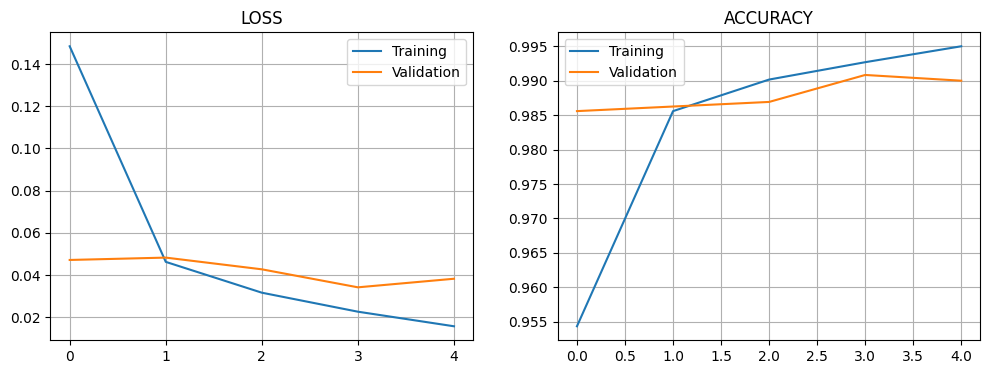

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('LOSS')
plt.grid(True)
plt.legend(['Training', 'Validation'])
plt.xticks(range(5))

plt.subplot(1, 2, 2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('ACCURACY')
plt.grid(True)
plt.legend(['Training', 'Validation'])
plt.xticks(range(5))

plt.show()